In [20]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import random
import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
latent_dims = 128

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './data',
        train=True,
        transform=torchvision.transforms.ToTensor(),
        download=True),
    batch_size=64,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './data',
        train=False,
        transform=torchvision.transforms.ToTensor(),
        download=True),
    batch_size=64,
    shuffle=False
)

In [11]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU()
        )

        self.linear1 = nn.Linear(32*24*24, latent_dims)
        self.linear2 = nn.Linear(32*24*24, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(self.conv(x), start_dim=1)
        mu =  self.linear1(x)
        sigma = torch.exp(self.linear2(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [15]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()

        self.linear = nn.Linear(latent_dims, 32*24*24)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3)
        )

    def forward(self, z):
        z = self.linear(z)
        z = z.view(-1, 32, 24, 24)
        return torch.sigmoid(self.deconv(z))

In [16]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [17]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [18]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, train_loader, epochs=20)

100%|██████████| 20/20 [04:22<00:00, 13.13s/it]


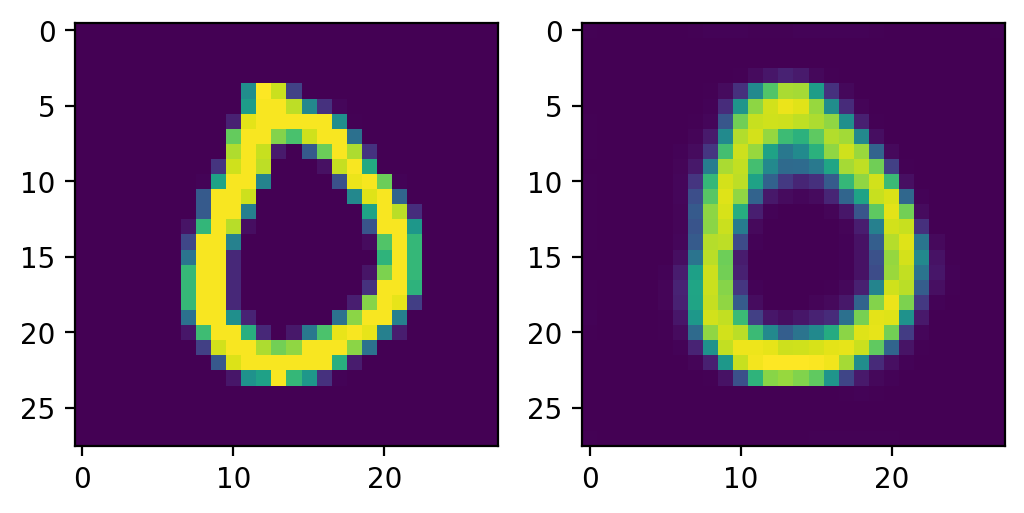

In [21]:
vae.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out = vae(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break